 # 1. Постановка задачи

## 1.1 Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. 
Заказчик хочет использовать разработанную модель для имитации технологического процесса

## 1.2 Описание технологического процесса

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

## 1.3 Описание даннных

Данные состоят из нескольких файлов, полученных из разных источников:  
- data_arc_new.csv — данные об электродах;  
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);  
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);  
- data_gas_new.csv — данные о продувке сплава газом;  
- data_temp_new.csv — результаты измерения температуры;  
- data_wire_new.csv — данные о проволочных материалах (объём);  
- data_wire_time_new.csv — данные о проволочных материалах (время)

Файл data_arc_new.csv

- key — номер партии;
- Начало нагрева дугой — время начала нагрева;
- Конец нагрева дугой — время окончания нагрева;
- Активная мощность — значение активной мощности;
- Реактивная мощность — значение реактивной мощности.

Файл data_bulk_new.cs:

- key — номер партии;  
- Bulk 1 … Bulk 15 — объём подаваемого материала.

Файл data_bulk_time_new.csv:
- key — номер партии;
- Bulk 1 … Bulk 15 — время подачи материала.

Файл data_gas_new.csv:
- key — номер партии;
- Газ 1 — объём подаваемого газа.

Файл data_temp_new.csv:

- key — номер партии;
- Время замера — время замера;
- Температура — значение температуры.

Файл data_wire_new.csv:

- key — номер партии;
- Wire 1 … Wire 15 — объём подаваемых проволочных материалов

Файл data_wire_time_new.csv

- key — номер партии;
- Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## 1.4 Постановка задчи

Построить модель, которая предскажет температуру в системе "печь-ковш"(кислородного конвертера) при выплавке стали кислородно-конвертерным способом в конвертерном цеху металургического комбината.

Модель должна иметь метрику MAE < 6.8 на тестовой выборке

# 2. Импорт библиотек и датасета

## 2.1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

from IPython.core.display import display, HTML;
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.pipeline import make_pipeline

/var/folders/5m/tbwsb3vs6734vbbw653my9v00000gp/T/ipykernel_38939/2260187450.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML;


In [2]:
warnings.filterwarnings('ignore') #Игнорируем ошибки

In [3]:
display(HTML("<style>.container { width:90% !important; }</style>")) # Изменяем ширину тетради

## 2.2. Импорт датасета

In [4]:
def import_data(pth1:str, pth2:str) -> pd.DataFrame:
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
         df = pd.read_csv(pth2)
    return df

In [5]:
pth1 = ['https://code.s3.yandex.net/datasets/data_arc_new.csv',
        'https://code.s3.yandex.net/datasets/data_bulk_new.csv',
        'https://code.s3.yandex.net/datasets/data_bulk_time_new.csv',
        'https://code.s3.yandex.net/datasets/data_gas_new.csv',
        'https://code.s3.yandex.net/datasets/data_temp_new.csv',
        'https://code.s3.yandex.net/datasets/data_wire_new.csv',
        'https://code.s3.yandex.net/datasets/data_wire_time_new.csv'
]

In [6]:
pth2 = ['/Documents/GitHub/final_project/data_arc_new.csv', 
        '/Documents/GitHub/final_project/data_bulk_new.csv',
        '/Documents/GitHub/final_project/data_bulk_time_new.csv',
        '/Documents/GitHub/final_project/data_gas_new.csv',
        '/Documents/GitHub/final_project/data_temp_new.csv',
        '/Documents/GitHub/final_project/data_wire_new.csv',
        '/Documents/GitHub/final_project/data_wire_time_new.csv'
]

In [7]:
arc_new = import_data(pth1[0], pth2[0]) #данные об электродах;
bulk_new = import_data(pth1[1], pth2[1]) #данные о подаче сыпучих материалов (объём);  
bulk_time_new = import_data(pth1[2], pth2[2]) #данные о подаче сыпучих материалов (время);  
gas_new = import_data(pth1[3], pth2[3]) #результаты измерения температуры;
temp_new = import_data(pth1[4], pth2[4]) #данные о проволочных материалах (объём);  
wire_new = import_data(pth1[5], pth2[5])#данные о проволочных материалах (объем);
wire_time_new = import_data(pth1[6], pth2[6]) #данные о проволочных материалах (время)

In [8]:
arc_new.info()
arc_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9498,2061,2019-07-25 15:25:30,2019-07-25 15:28:17,0.605682,0.457226
10752,2339,2019-08-04 13:33:17,2019-08-04 13:38:25,0.480278,0.321705
5056,1096,2019-06-14 11:42:42,2019-06-14 11:44:32,1.196343,0.994612
13927,3022,2019-08-30 04:35:26,2019-08-30 04:38:56,0.480744,0.313167
14421,3136,2019-09-03 02:06:42,2019-09-03 02:10:51,0.456376,0.287833


In [9]:
bulk_new.info()
bulk_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
2570,2668,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,NaN,74.0,158.0,NaN,100.0,206.0
685,718,NaN,NaN,70.0,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,154.0,157.0
240,257,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,155.0,155.0
1209,1258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.0,NaN,221.0,148.0
1697,1757,NaN,NaN,89.0,NaN,74.0,88.0,NaN,NaN,NaN,NaN,NaN,207.0,NaN,101.0,204.0


In [10]:
bulk_time_new.info()
bulk_time_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
343,368,NaN,NaN,2019-05-17 21:09:46,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-17 21:07:18,NaN,2019-05-17 21:00:32,NaN,2019-05-17 20:56:09,NaN
3067,3176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-04 10:03:22,NaN,2019-09-04 10:43:33,NaN,2019-09-04 10:33:05,2019-09-04 10:10:15
2633,2732,2019-08-19 02:38:32,NaN,NaN,2019-08-19 02:33:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-19 02:27:28,NaN,2019-08-19 02:21:49,2019-08-19 02:16:27
658,690,2019-05-30 10:37:34,NaN,NaN,NaN,NaN,2019-05-30 10:25:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30 10:13:36,NaN
36,37,NaN,NaN,2019-05-04 17:03:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 16:57:40,NaN,2019-05-04 16:53:16,2019-05-04 16:45:06


In [11]:
gas_new.info()
gas_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
2530,2533,7.542188
1093,1096,18.188984
1898,1901,6.418470
1652,1655,9.894554
2588,2591,11.003178


In [12]:
temp_new.info()
temp_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


,key,Время замера,Температура
17412,3116,2019-09-02 06:31:12,1560.0
12908,2308,2019-08-03 13:59:25,1594.0
14212,2548,2019-08-12 07:42:31,NaN
3781,675,2019-05-29 18:36:46,1574.0
8543,1525,2019-06-29 20:34:49,1662.0


In [13]:
wire_new.info()
wire_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
600,636,82.321197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2472,2599,61.064636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1287,1356,100.245597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2842,2995,127.589272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
678,721,89.247596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
wire_time_new.info()
wire_time_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2888,3047,2019-08-31 01:08:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506,541,2019-05-24 00:21:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2343,2468,2019-08-09 10:53:50,2019-08-09 10:53:50,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-09 10:17:13
804,858,2019-06-06 01:42:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3031,3190,2019-09-04 23:03:09,2019-09-04 22:56:51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3.Исследовательский анализ и предобработка данных

## 3.1 Предобработка данных

In [15]:
def print_info(df:pd.DataFrame):
    print('Пропуски')
    print(df.isna().sum())
    print('Дубликаты')
    print(df.duplicated().sum())
    return

**arc_new**

Приведем наименования признаков в соответствие со snake_case

In [16]:
arc_new.columns = ['key', 'start_of_heating', 'end_of_heating', 'active_power', 'reactive_power']

In [17]:
arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               14876 non-null  int64  
 1   start_of_heating  14876 non-null  object 
 2   end_of_heating    14876 non-null  object 
 3   active_power      14876 non-null  float64
 4   reactive_power    14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Приведем время к date_time

In [18]:
arc_new.start_of_heating = pd.to_datetime(arc_new.start_of_heating, infer_datetime_format = True) 
arc_new.end_of_heating = pd.to_datetime(arc_new.end_of_heating, infer_datetime_format = True) 

In [19]:
arc_new.info()
arc_new.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   key               14876 non-null  int64         
 1   start_of_heating  14876 non-null  datetime64[ns]
 2   end_of_heating    14876 non-null  datetime64[ns]
 3   active_power      14876 non-null  float64       
 4   reactive_power    14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,start_of_heating,end_of_heating,active_power,reactive_power
5453,1186,2019-06-17 10:53:55,2019-06-17 10:57:12,0.517045,0.352162
225,47,2019-05-05 07:19:19,2019-05-05 07:21:51,0.557313,0.434119
5756,1252,2019-06-19 19:49:13,2019-06-19 19:54:16,0.916476,0.633097
10560,2294,2019-08-03 01:38:43,2019-08-03 01:40:30,0.789839,0.566339
10239,2222,2019-07-31 12:35:33,2019-07-31 12:37:44,1.013061,0.668043


Проверим пропуски

In [20]:
print_info(arc_new)

Пропуски
key                 0
start_of_heating    0
end_of_heating      0
active_power        0
reactive_power      0
dtype: int64
Дубликаты
0


Пропусков явных дубикатов нет

In [21]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power
count,14876.000000,14876,14876,14876.000000,14876.000000
mean,1615.220422,2019-07-05 12:25:51.921081088,2019-07-05 12:28:43.592027392,0.662752,0.438986
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,-715.479924
25%,806.000000,2019-06-03 23:18:23.249999872,2019-06-03 23:21:35,0.467115,0.337175
50%,1617.000000,2019-07-03 01:31:26.500000,2019-07-03 01:35:13,0.599587,0.441639
75%,2429.000000,2019-08-07 22:52:20.750000128,2019-08-07 22:56:47,0.830070,0.608201
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.571502,NaN,NaN,0.258885,5.873485


значения меньше 0 для реактивной мощности явно ошибочны

In [22]:
arc_new[arc_new.reactive_power > 0].count()

key                 14875
start_of_heating    14875
end_of_heating      14875
active_power        14875
reactive_power      14875
dtype: int64

In [23]:
arc_new = arc_new[arc_new.reactive_power > 0]

In [24]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power
count,14875.000000,14875,14875,14875.000000,14875.000000
mean,1615.186756,2019-07-05 12:23:40.763025152,2019-07-05 12:26:32.438184960,0.662749,0.487115
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777
25%,806.000000,2019-06-03 23:13:02.500000,2019-06-03 23:16:13,0.467115,0.337190
50%,1617.000000,2019-07-03 01:28:12,2019-07-03 01:31:27,0.599578,0.441665
75%,2429.000000,2019-08-07 22:54:16.500000,2019-08-07 22:57:54,0.830135,0.608223
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284
std,934.593897,NaN,NaN,0.258894,0.197612


**bulk_new**

Проверим пропуски и дубликаты

In [25]:
print_info(bulk_new)

Пропуски
key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64
Дубликаты
0


Скорее всего пропуски связаны с тем, что в указанные плавки материалы не подавались (Объем 0). Логично заполнить данные пропуски 0

In [26]:
bulk_new = bulk_new.fillna(0)

In [27]:
print_info(bulk_new)

Пропуски
key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64
Дубликаты
0


Приведем признаки к snake_case

In [28]:
bulk_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [29]:
bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


In [30]:
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Отрицательных значений нет

**bulk_time_new**

Приведем к snake_case

In [31]:
bulk_time_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [32]:
columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

В данном случае пропуски придется оставить, так как если материал не подавался в принципе, время подачи определить нельзя

Приведем к date_time

In [33]:
def to_datetime(columns:str, df:pd.DataFrame) -> pd.DataFrame:
    for column in columns:
        df[column] = pd.to_datetime(df[column], infer_datetime_format = True, errors='coerce') 
    return df

In [34]:
bulk_time_new = to_datetime(columns, bulk_time_new)

In [35]:
print_info(bulk_time_new)

Пропуски
key           0
bulk_1     2877
bulk_2     3107
bulk_3     1831
bulk_4     2115
bulk_5     3052
bulk_6     2553
bulk_7     3104
bulk_8     3128
bulk_9     3110
bulk_10    2953
bulk_11    2952
bulk_12     679
bulk_13    3111
bulk_14     323
bulk_15     881
dtype: int64
Дубликаты
0


In [36]:
bulk_time_new.sample(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1589,1648,NaT,NaT,2019-07-03 23:45:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-03 23:41:14,NaT,2019-07-03 23:35:39,2019-07-03 23:29:39
1829,1891,NaT,NaT,2019-07-12 23:14:42,2019-07-12 23:03:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-07-12 23:38:12,NaT,2019-07-12 23:20:13,2019-07-12 23:14:42
1471,1527,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-29 22:13:34,NaT,2019-06-29 22:08:59,NaT
723,756,NaT,NaT,2019-06-01 21:44:33,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-01 21:39:47,NaT
1026,1072,NaT,NaT,2019-06-13 16:53:54,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-06-13 16:53:54,NaT,2019-06-13 16:50:53,2019-06-13 16:43:49


**gas_new**

In [37]:
print_info(gas_new)

Пропуски
key      0
Газ 1    0
dtype: int64
Дубликаты
0


Пропусков и дубликатов нет. Приведем признаки к snake_case

In [38]:
gas_new.columns = ['key', 'gas']

In [39]:
gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**temp_new**

Посмотрим пропуски и дубликаты

In [40]:
print_info(temp_new)

Пропуски
key                0
Время замера       0
Температура     3427
dtype: int64
Дубликаты
0


К сожалению в данном случае пропуски не заполнить. Так как это целевой признак, придется удалить пропуски. 

In [41]:
temp_new = temp_new.dropna()

Приведем столбцы к snake_case

In [42]:
temp_new.columns = ['key', 'measurment_time', 'temperature']

In [43]:
temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              14665 non-null  int64  
 1   measurment_time  14665 non-null  object 
 2   temperature      14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 458.3+ KB


**wire_new**

In [44]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [45]:
print_info(wire_new)

Пропуски
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Дубликаты
0


Скорее всего пропуски - это отсутсвие материалов, т.е 0

In [46]:
wire_new = wire_new.fillna(0)

Приведем признаки к snake_case

In [47]:
wire_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [48]:
wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**wire_time_new**

In [49]:
print_info(wire_time_new)

Пропуски
key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64
Дубликаты
0


Здесь с пропусками ничего сделать не поулчится. Приведем к snake_case и date_time

In [50]:
wire_time_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']
columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [51]:
wire_time_new = to_datetime(columns, wire_time_new)

## 3.2 Исследовательский анализ данных

Очевидно, что время подачи того или инного материала вряд ли как-то влияют на температуру. Будум рассматривать нагрев элетродами(arc_new), объем подаваемых материалов и проволки (bulk_new и wire_new), объем газа (gas_new), результаты измерения температуры

**arc_new**

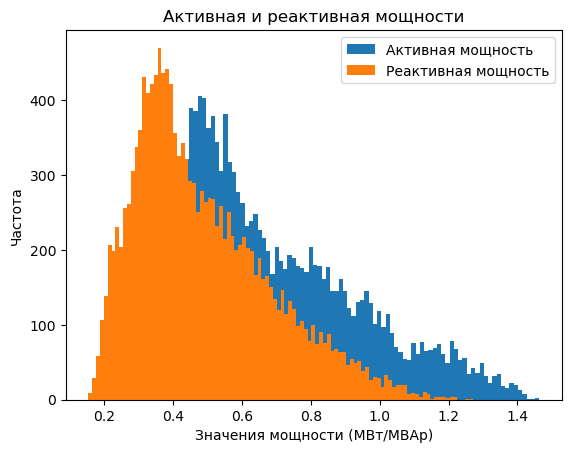

In [52]:
plt.title('Активная и реактивная мощности')
plt.hist(arc_new.active_power, bins= 100, label='Активная мощность');
plt.hist(arc_new.reactive_power, bins= 100, label='Реактивная мощность');
plt.legend(['Активная мощность', 'Реактивная мощность'])
plt.xlabel("Значения мощности (МВт/МВАр)")  
plt.ylabel("Частота")

plt.show()

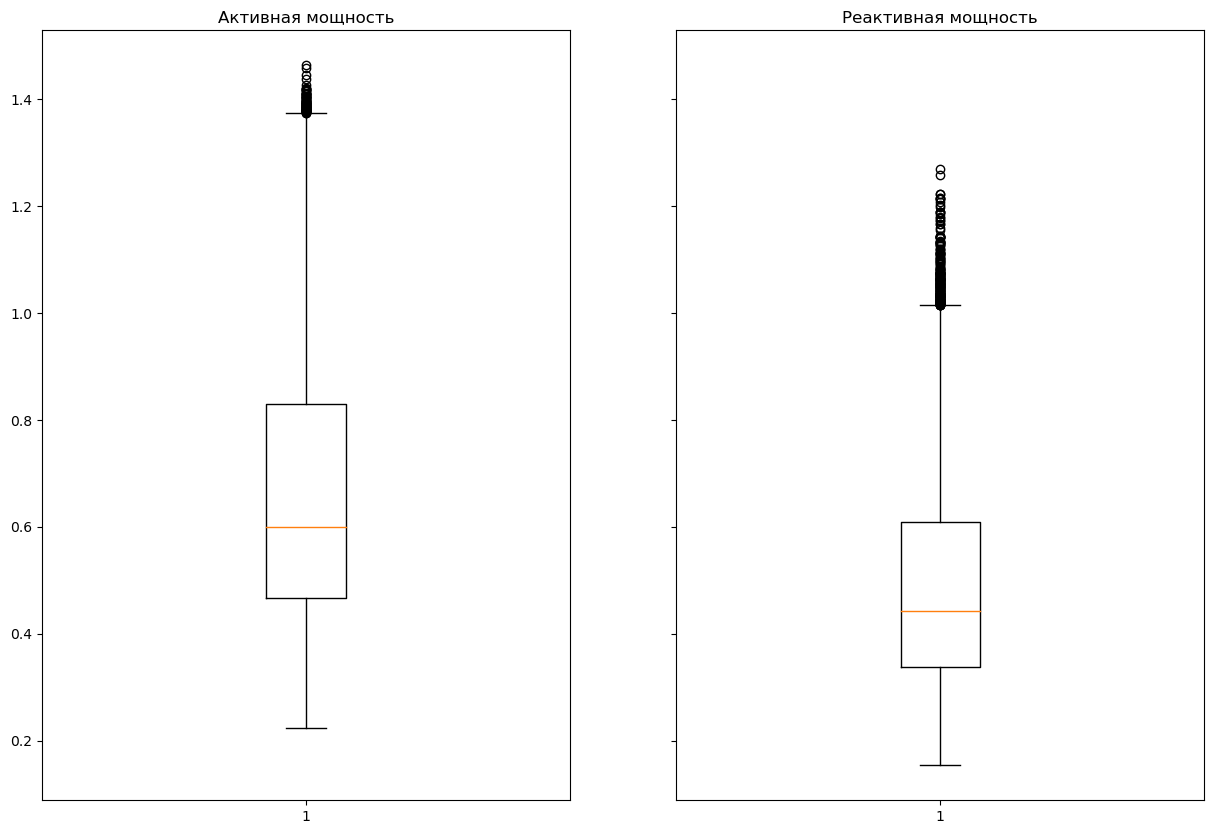

In [53]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 10))
ax1.boxplot(arc_new.active_power);
ax1.set_title('Активная мощность');
ax2.boxplot(arc_new.reactive_power);
ax2.set_title('Реактивная мощность');

Из гистограмм видно, что активная и реактивная мощность сильно коррелируют друг другом (почти линейная зависимость). Для уменьшения эффекта мультиколинеарности расчитаем полную мощность

In [54]:
arc_new['full_power'] = (arc_new['active_power']**2 + arc_new['reactive_power']**2)**0.5

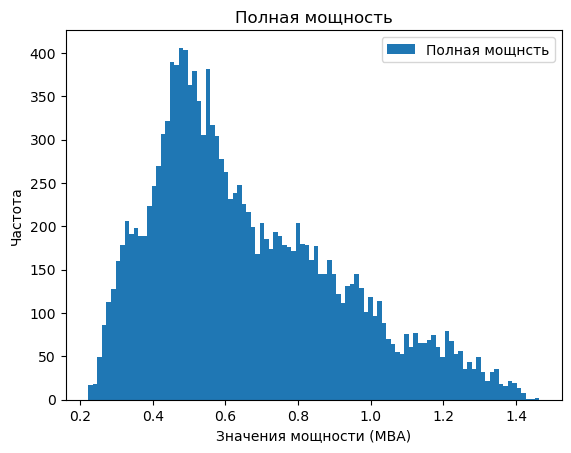

In [55]:
plt.title('Полная мощность')
plt.hist(arc_new.active_power, bins= 100, label='Полная мощность');

plt.legend(['Полная мощнсть'])
plt.xlabel("Значения мощности (МВА)")  
plt.ylabel("Частота")

plt.show()

Даты начала и конца сами по себе ничего не скажут, а продолжительность нагрева может быть важной

In [56]:
arc_new['time_of_heating'] = arc_new.end_of_heating - arc_new.start_of_heating

In [57]:
arc_new['time_of_heating'] = arc_new['time_of_heating'].map(lambda x: x.total_seconds()) #Переведем все в секунды

Text(0, 0.5, 'Частота')

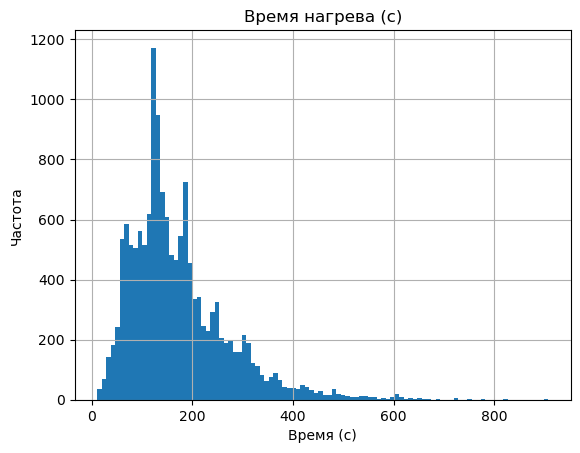

In [58]:
plt.title('Время нагрева (с)')
arc_new.time_of_heating.hist(bins = 100);
plt.xlabel("Время (с)")  
plt.ylabel("Частота")

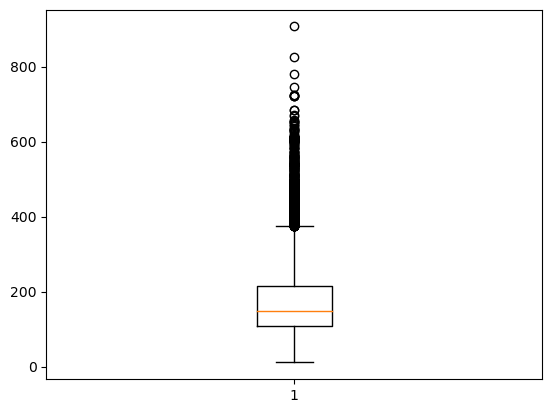

In [59]:
plt.boxplot(arc_new.time_of_heating);
ax1.set_title('Время нагрева');

Присутствует большое количество выбросов 

In [60]:
arc_new.describe()

,key,start_of_heating,end_of_heating,active_power,reactive_power,full_power,time_of_heating
count,14875.000000,14875,14875,14875.000000,14875.000000,14875.000000,14875.000000
mean,1615.186756,2019-07-05 12:23:40.763025152,2019-07-05 12:26:32.438184960,0.662749,0.487115,0.823385,171.675160
min,1.000000,2019-05-03 11:02:14,2019-05-03 11:06:02,0.223120,0.153777,0.275718,11.000000
25%,806.000000,2019-06-03 23:13:02.500000,2019-06-03 23:16:13,0.467115,0.337190,0.578839,107.000000
50%,1617.000000,2019-07-03 01:28:12,2019-07-03 01:31:27,0.599578,0.441665,0.746554,147.000000
75%,2429.000000,2019-08-07 22:54:16.500000,2019-08-07 22:57:54,0.830135,0.608223,1.030402,214.000000
max,3241.000000,2019-09-06 17:24:54,2019-09-06 17:26:15,1.463773,1.270284,1.898158,907.000000
std,934.593897,NaN,NaN,0.258894,0.197612,0.323470,98.188759


Рассмотрим средне и суммрное потребление электроэнергии при плавке каждой партии. Для этого с агрегируем датафрейм по ключу

In [61]:
arc_preprocessed = (arc_new.
                    drop(columns=['start_of_heating','end_of_heating', 'active_power', 'reactive_power'])
                    .groupby('key')
                    .agg('sum'))

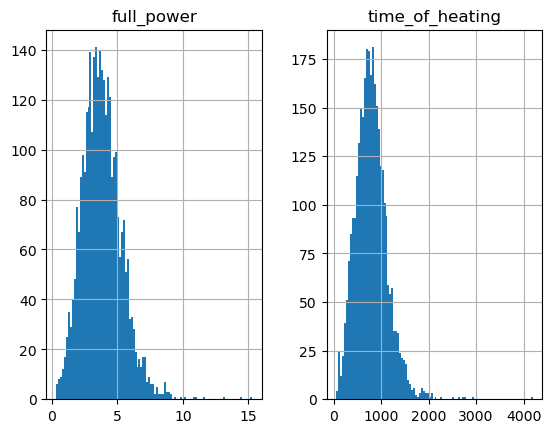

In [62]:
arc_preprocessed.hist(bins = 100);

In [63]:
arc_new.groupby('key').full_power.agg('mean')

key
1       0.743747
2       0.647087
3       1.003845
4       0.850010
5       0.704245
          ...   
3237    0.650131
3238    0.574646
3239    0.751810
3240    0.816584
3241    0.744576
Name: full_power, Length: 3214, dtype: float64

Так как в дальнейшем нам пданные за каждую итерацию не понадобятся, выберем среднее 

Вывод: 

- храктер распределения - распределение пуассона (усредненно для каждой партии близко к нормальному)
- присутствуют выбросы за гранцие 4-ого квартиля
- В среднем на разогрев уходит 171 секунда при 0.663 МВт активной мощности и 0.487 МВАр реактивной мощности

**gas_new**

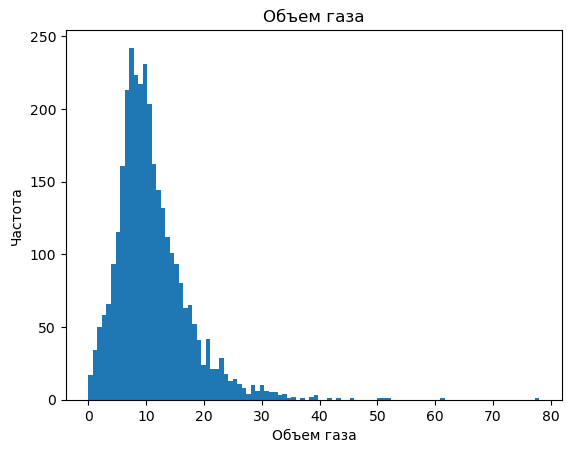

In [64]:
plt.title('Объем газа')
plt.hist(gas_new.gas, bins= 100);
plt.xlabel("Объем газа")  
plt.ylabel("Частота")
plt.show()

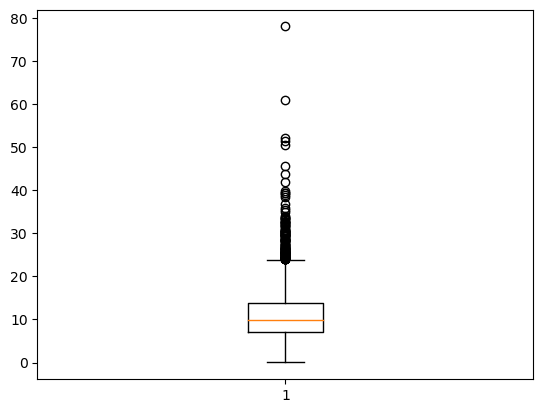

In [65]:
plt.boxplot(gas_new.gas);
ax1.set_title('Объем газа');

In [66]:
gas_new.describe()

,key,gas
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Вывод: 

- храктер распределения - распределение пуассона
- присутствуют выбросы за гранцей 4-ого квартиля
- В среднем за плавку подается 11 чего-то (скорее всего м3) кислорода 

**temp_new**

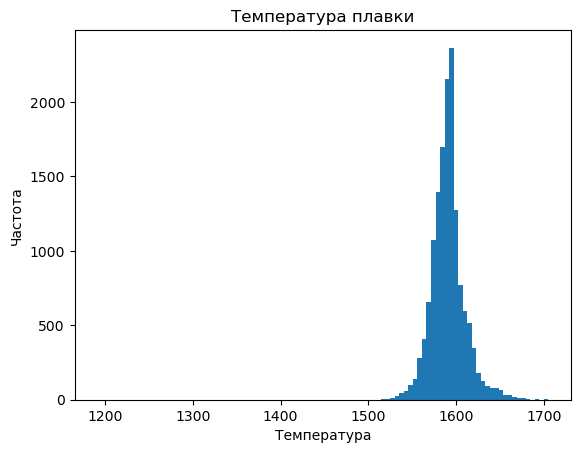

In [67]:
plt.title('Температура плавки')
plt.hist(temp_new.temperature, bins= 100);
plt.xlabel("Температура")  
plt.ylabel("Частота")
plt.show()

In [68]:
temp_new.temperature.describe()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: temperature, dtype: float64

In [69]:
temp_new.sample(5)

,key,measurment_time,temperature
5795,1031,2019-06-12 06:00:30,1584.0
3459,620,2019-05-26 20:57:52,1586.0
12938,2314,2019-08-03 18:13:41,1584.0
17378,3108,2019-09-02 01:09:54,1553.0
17761,3178,2019-09-04 12:02:07,1607.0


По условию задачи температура ниже 1500 град.С считется нарушением технологического процесса

In [70]:
temp_new = temp_new[temp_new.temperature > 1500]

Посмотрим сколько в среднем итерции проводится для одной партии

In [71]:
temp_new.key.value_counts()

key
2108    17
1689    16
1513    16
46      14
322     14
        ..
2747     1
2748     1
2749     1
2750     1
3241     1
Name: count, Length: 3215, dtype: int64

До 17 итераций на каждую партию

Для подготовки признков требуется выделить начальную темпертуру и температуру после последней итерации

In [72]:
sup = temp_new[temp_new.key == 2447] 
sup[sup.measurment_time == sup.measurment_time.min()].temperature.values[0]

1640.0

In [73]:
sup[sup.measurment_time == sup.measurment_time.max()].temperature.values[0]

1594.0

In [74]:
def first_last_temperature(df: pd.DataFrame) -> pd.DataFrame:

    to_join = pd.DataFrame(columns = ['first_temperature', 'last_temperature'], index = df.key.unique())
    for key in df.key.unique():
        sup = temp_new[temp_new.key == key]
        to_join.loc[key, 'first_temperature'] = float(sup[sup.measurment_time == sup.measurment_time.min()].temperature.values[0])
        to_join.loc[key , 'last_temperature'] = float(sup[sup.measurment_time == sup.measurment_time.max()].temperature.values[0])
    return to_join

In [75]:
temp_to_join = first_last_temperature(temp_new)

In [76]:
temp_to_join.first_temperature = temp_to_join.first_temperature.astype(float)
temp_to_join.last_temperature = temp_to_join.last_temperature.astype(float)

In [77]:
temp_to_join.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3215 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   first_temperature  3215 non-null   float64
 1   last_temperature   3215 non-null   float64
dtypes: float64(2)
memory usage: 204.4 KB


In [78]:
temp_to_join['key'] = temp_to_join.index

In [79]:
temp_to_join = temp_to_join.reset_index(drop = True)

In [80]:
temp_to_join.sample(5)

,first_temperature,last_temperature,key
2852,1596.0,1596.0,2877
3015,1643.0,1643.0,3040
519,1570.0,1585.0,525
991,1629.0,1591.0,1003
226,1617.0,1616.0,229


In [81]:
temp_to_join.isna().sum()

first_temperature    0
last_temperature     0
key                  0
dtype: int64

Вывод: 

- Храктер распредения - нормальный
- Температура плавки в среднем изменяется в пределах +- 10 град.С (от 1580 до 1599 град.С)
- В среднем температура плавки 1590 град.С

**bulk_new**

In [82]:
def plot_cycle(df:pd.DataFrame, columns:list, string:int, col:int, bins):
    fig, axs = plt.subplots(string,col, figsize= (20,20), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()

    for i in range(len(columns)):

        axs[i].hist(df[columns[i]],bins)
        axs[i].set_title(columns[i])
    return 

In [83]:
columns = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 
                    'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 
                    'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

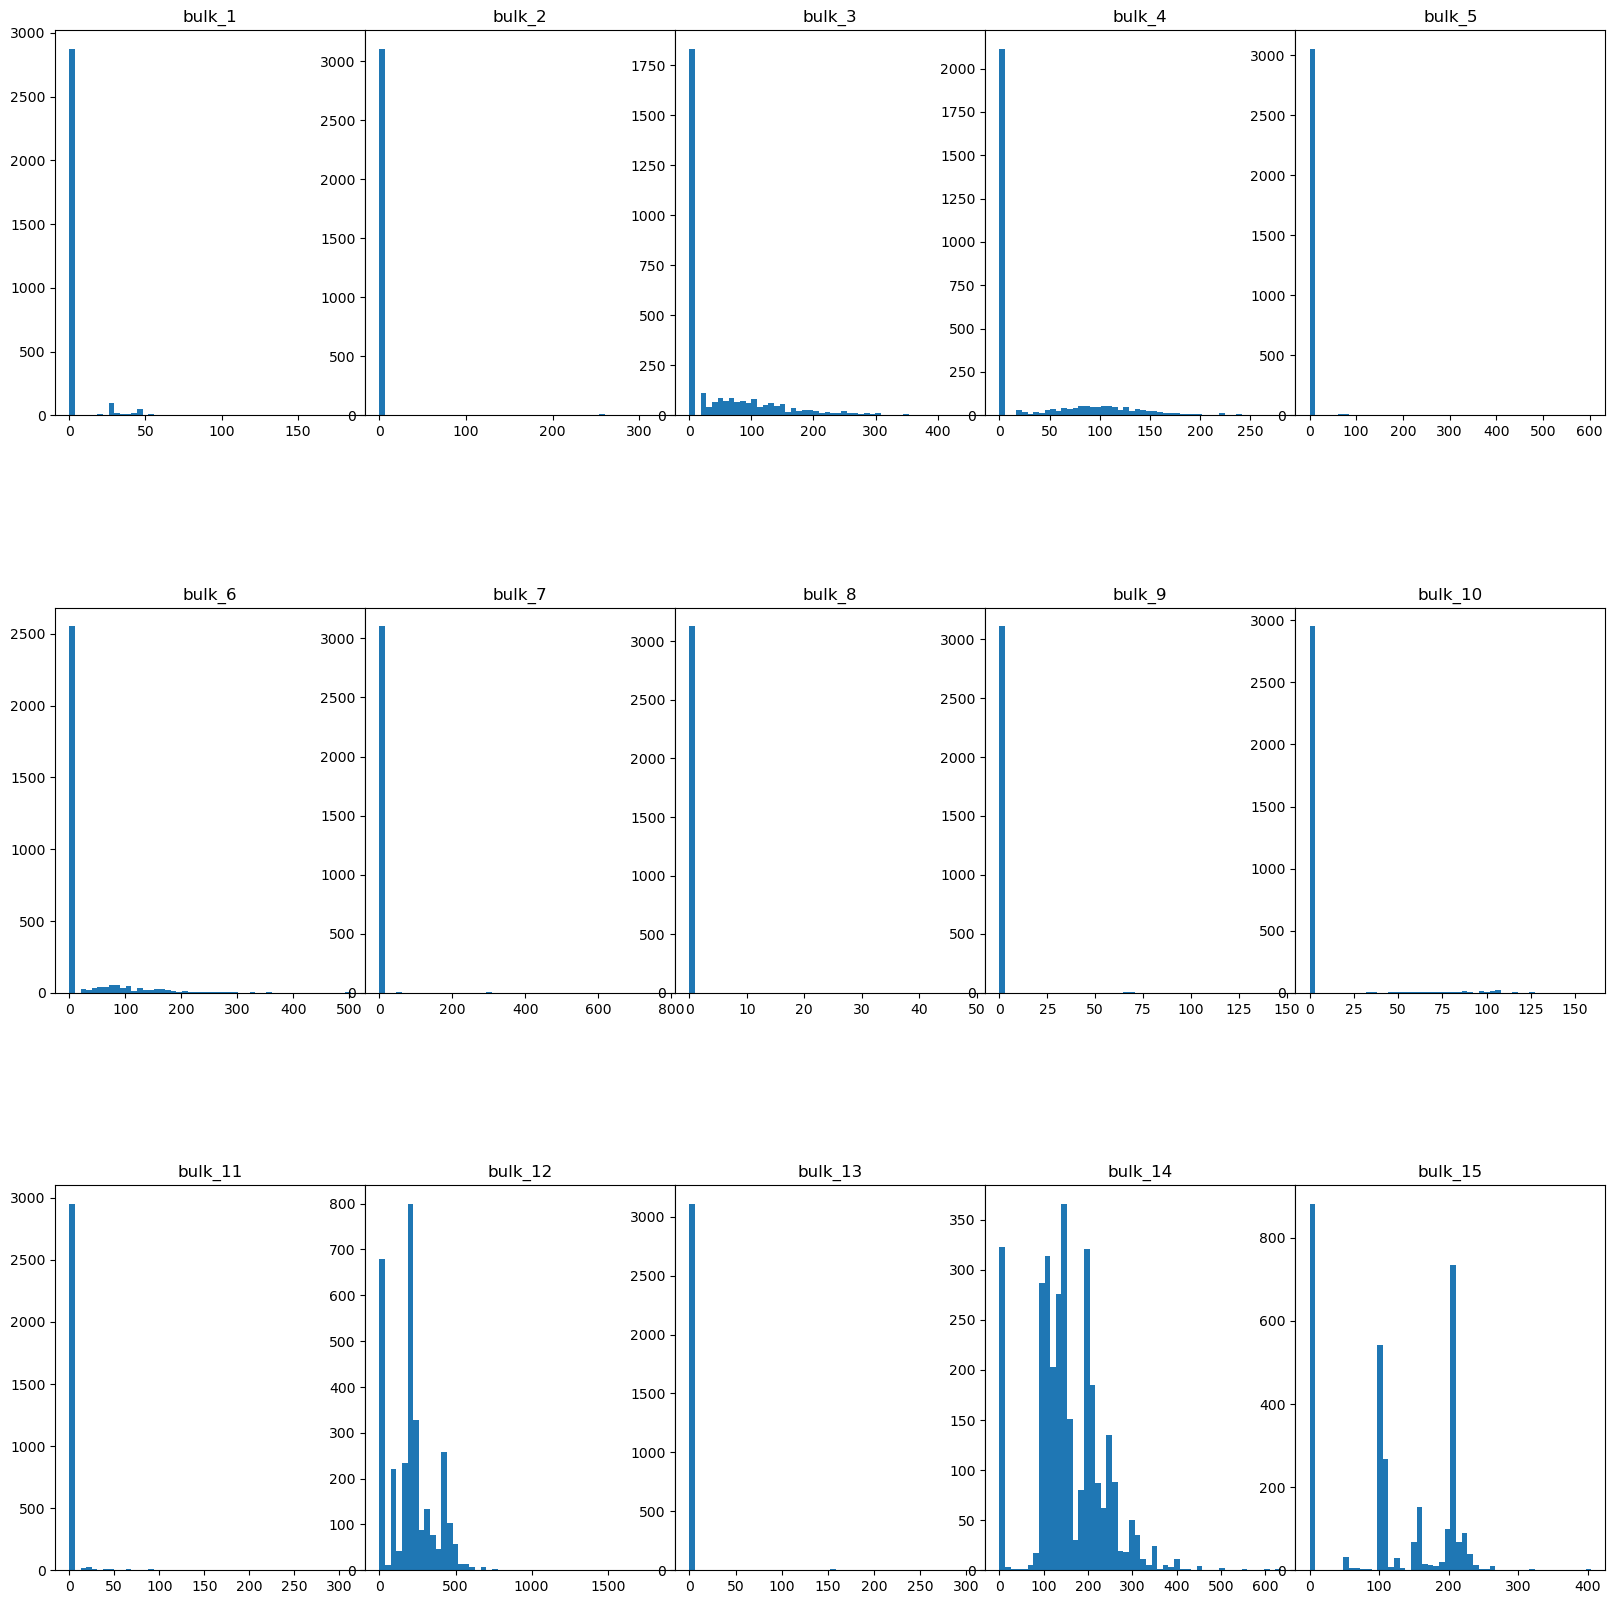

In [84]:
plot_cycle(bulk_new, columns, 3, 5, 50)

In [85]:
bulk_new.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Вывод: 

- Материалы 1..11, 13 практически всегда подются в одинаковых количествах
- Материалы 12, 14, 15 могут подаваться в разных количествах в зависимости от режима технологического процесса

**wire_new**

In [86]:
columns = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

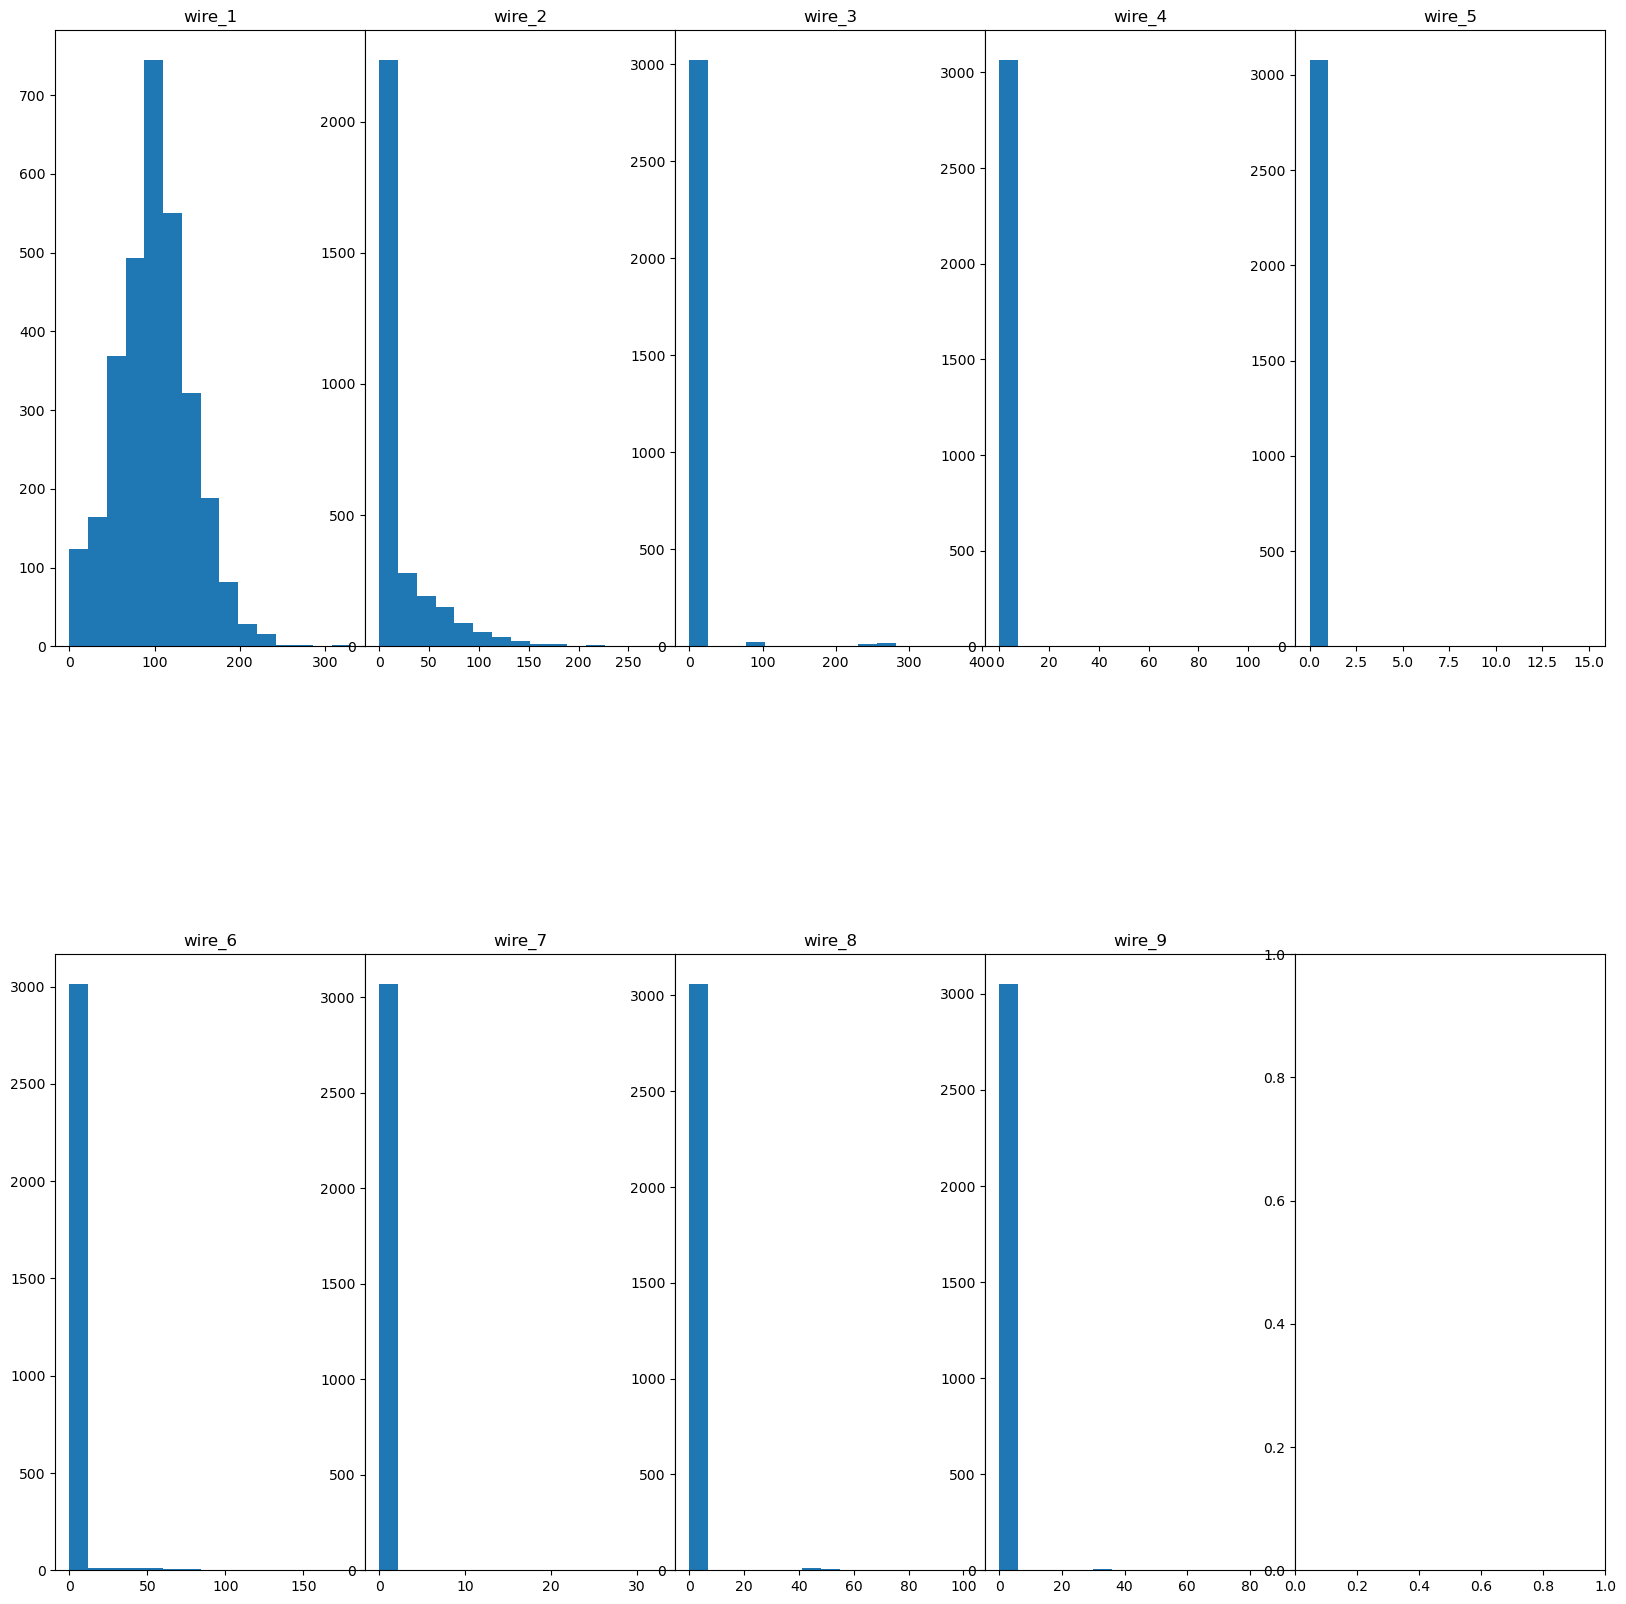

In [87]:
plot_cycle(wire_new, columns, 2,5,15)

In [88]:
wire_new.describe()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Вывод: 

- Проволка 2...9 практически всегда подются в одинаковых количествах
- Проволка 1 может подаваться в разных количествах в зависимости от режима технологического процесса

**Общий вывод по этапу:** 

Очевидно что время подачи материала и проволки, время замеров и другие "времена" не требуются для обучения модели так как с темпертурой плавки никак не коррелируют. Их в итоговый датафрейм объединять не будем

# 4 Объединение данных

In [89]:
temp_to_join.index = temp_to_join.key
bulk_new.index = bulk_new.key
gas_new.index = gas_new.key
wire_new.index = wire_new.key

In [90]:
temp_to_join = temp_to_join.drop(columns= ['key'])
bulk_to_join = bulk_new.drop(columns= ['key'])
gas_to_join = gas_new.drop(columns= ['key'])
wire_to_join = wire_new.drop(columns= ['key'])

In [91]:
united_new = (arc_preprocessed
              .join(temp_to_join, how='inner')
              .join(bulk_to_join, how='inner')
              .join(gas_to_join, how='inner')
              .join(wire_to_join, how='inner'))

In [92]:
united_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3021 entries, 1 to 3241
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   full_power         3021 non-null   float64
 1   time_of_heating    3021 non-null   float64
 2   first_temperature  3021 non-null   float64
 3   last_temperature   3021 non-null   float64
 4   bulk_1             3021 non-null   float64
 5   bulk_2             3021 non-null   float64
 6   bulk_3             3021 non-null   float64
 7   bulk_4             3021 non-null   float64
 8   bulk_5             3021 non-null   float64
 9   bulk_6             3021 non-null   float64
 10  bulk_7             3021 non-null   float64
 11  bulk_8             3021 non-null   float64
 12  bulk_9             3021 non-null   float64
 13  bulk_10            3021 non-null   float64
 14  bulk_11            3021 non-null   float64
 15  bulk_12            3021 non-null   float64
 16  bulk_13            3021 non-n

In [93]:
united_new.sample(5)

,full_power,time_of_heating,first_temperature,last_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,...,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,,,,,,,,,,,,,
1092,2.922763,736.0,1619.0,1607.0,0.0,0.0,142.0,155.0,0.0,0.0,...,1.018285,220.147201,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
3088,1.882402,400.0,1600.0,1600.0,0.0,0.0,138.0,0.0,0.0,0.0,...,3.583961,47.087040,30.09968,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
2643,2.894420,705.0,1606.0,1606.0,0.0,0.0,0.0,120.0,0.0,0.0,...,11.585950,107.059677,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0
2107,5.862415,871.0,1641.0,1543.0,30.0,282.0,0.0,113.0,146.0,0.0,...,29.671167,9.085440,0.00000,93.165077,82.150638,0.0,99.219122,8.49004,0.0,0.0
2606,7.112118,1242.0,1590.0,1590.0,22.0,0.0,130.0,0.0,0.0,50.0,...,2.496178,181.403040,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0


In [94]:
len(united_new.columns)

29

In [95]:
united_new.isna().sum()

full_power           0
time_of_heating      0
first_temperature    0
last_temperature     0
bulk_1               0
bulk_2               0
bulk_3               0
bulk_4               0
bulk_5               0
bulk_6               0
bulk_7               0
bulk_8               0
bulk_9               0
bulk_10              0
bulk_11              0
bulk_12              0
bulk_13              0
bulk_14              0
bulk_15              0
gas                  0
wire_1               0
wire_2               0
wire_3               0
wire_4               0
wire_5               0
wire_6               0
wire_7               0
wire_8               0
wire_9               0
dtype: int64

# 5 Исследовательский анализ объединенного датафрейма

Скорее всего все имеющиеся признаки были уже добавлены. Построим распределения выбранных признаков

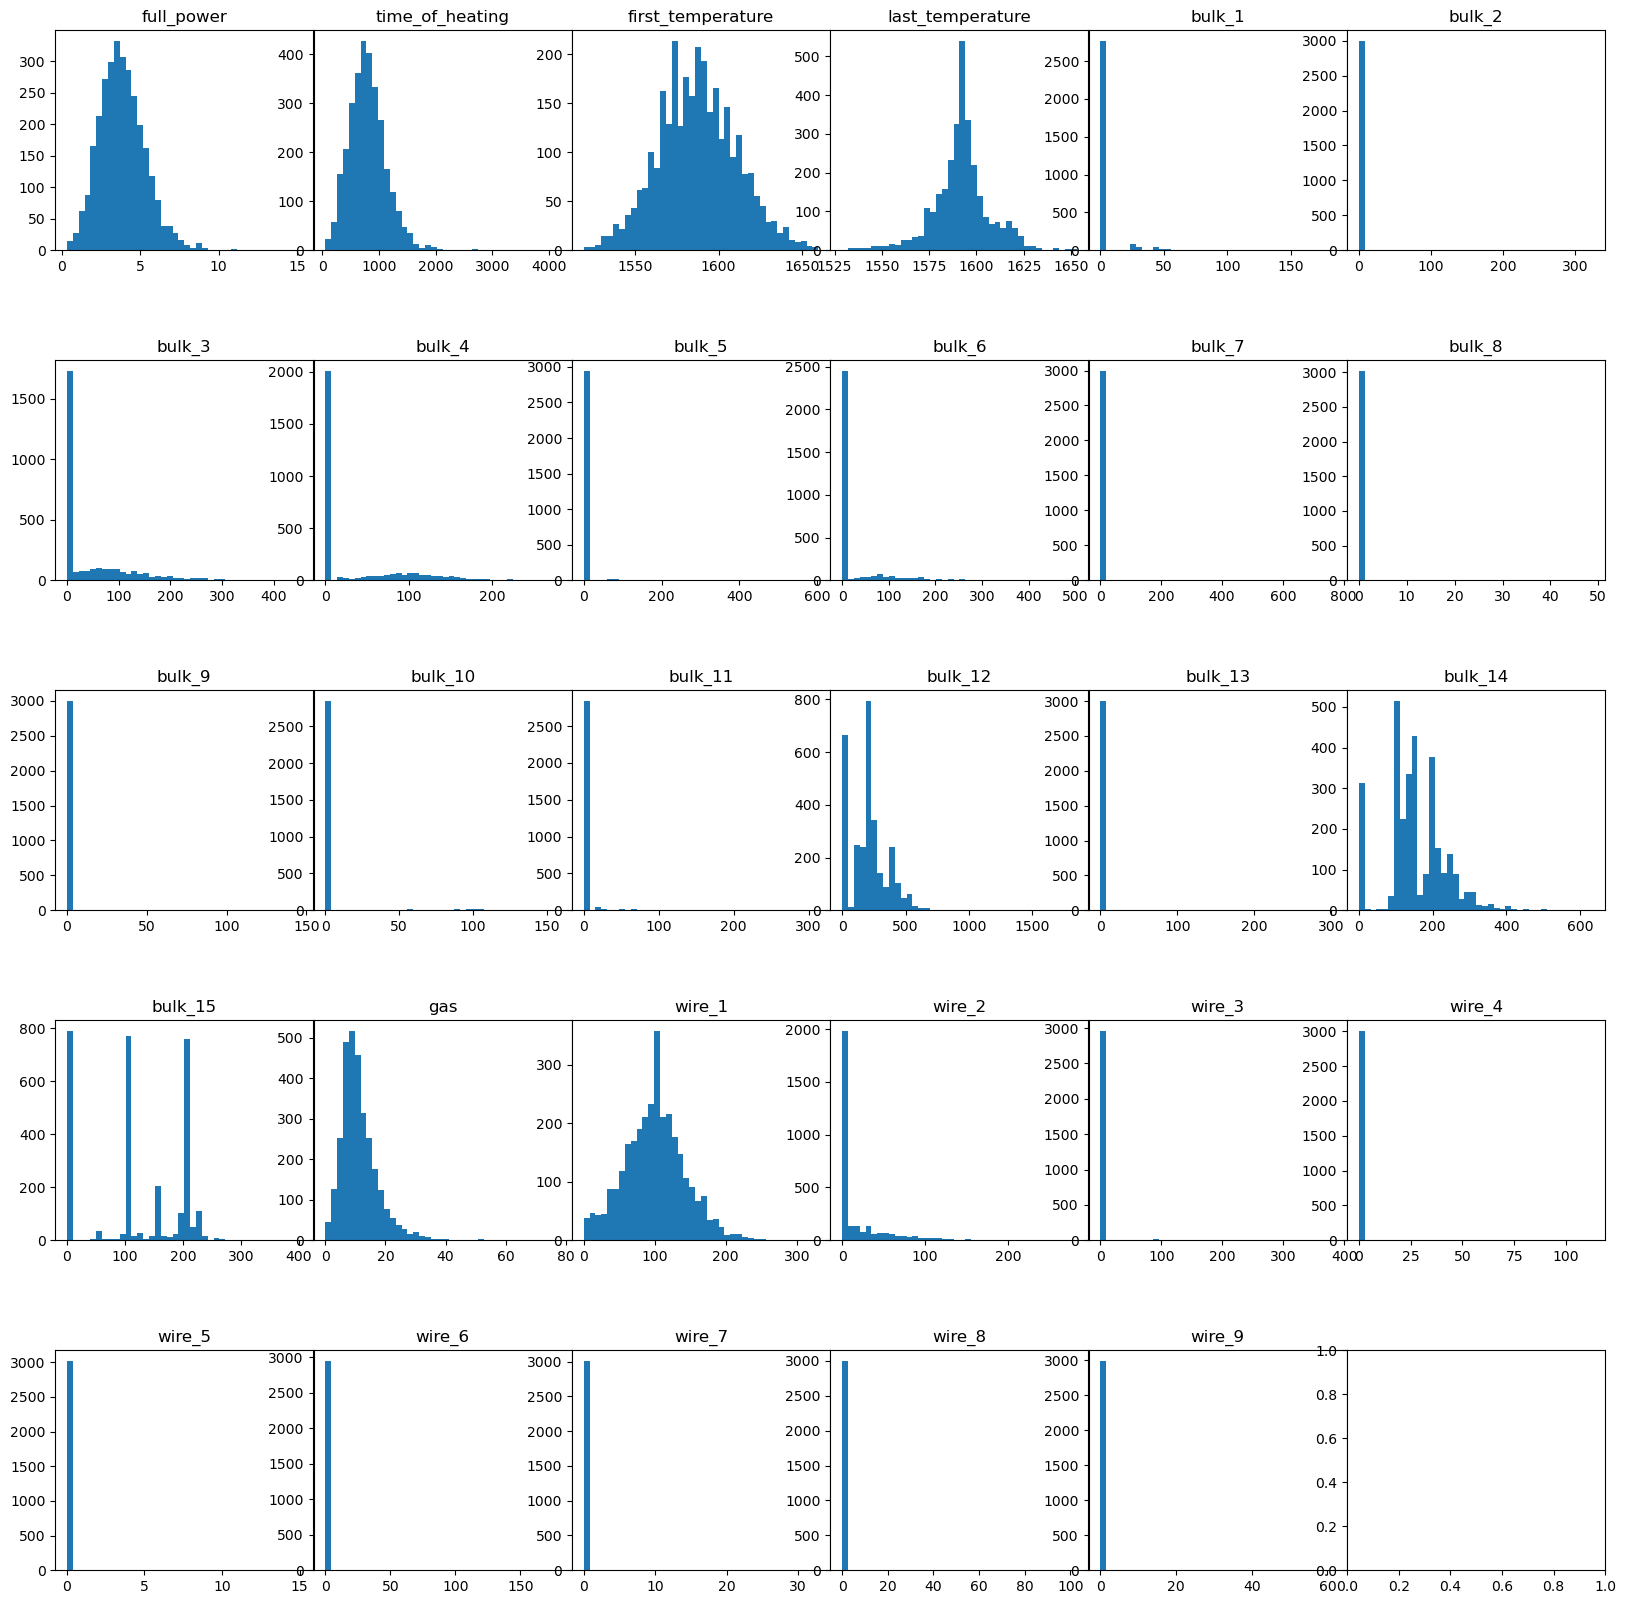

In [96]:
plot_cycle(united_new, united_new.columns, 5, 6, 40)

Посчитаем корреляции и построим матрицу корреляций

In [97]:
corr = united_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,full_power,time_of_heating,first_temperature,last_temperature,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,gas,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
full_power,1.000000,0.701323,-0.138835,0.076437,0.103388,0.133954,0.098305,0.012252,0.095516,0.140037,0.166710,-0.022502,0.034533,0.004656,0.040770,0.249545,0.098356,0.276521,0.131715,0.379004,0.137989,0.066720,0.071910,0.101944,0.076113,0.090110,0.080231,0.040335,-0.018683
time_of_heating,0.701323,1.000000,-0.395957,0.028363,0.102238,0.035241,0.099432,-0.024346,0.021640,0.142681,0.071173,-0.009856,0.013716,-0.011443,0.078311,0.457360,0.115297,0.434437,0.280717,0.389367,0.065766,0.048097,0.024301,0.050209,0.024549,0.046806,0.005796,0.018000,-0.008890
first_temperature,-0.138835,-0.395957,1.000000,0.523455,0.075530,0.143440,-0.104359,0.163366,0.063057,-0.135188,0.098490,-0.010366,-0.037451,0.043016,-0.113476,-0.091620,0.024008,-0.167792,-0.064934,0.044914,0.253134,-0.109002,0.009039,0.074428,0.027503,0.027739,0.061066,-0.034882,0.001614
last_temperature,0.076437,0.028363,0.523455,1.000000,-0.020373,0.025460,-0.051143,0.173277,-0.019754,-0.161797,-0.008876,-0.015721,-0.029269,0.062187,-0.114607,0.124820,0.006916,0.027028,0.135244,0.064030,0.273041,-0.166496,-0.014054,-0.081998,0.037394,-0.033012,0.046129,-0.026604,-0.011854
bulk_1,0.103388,0.102238,0.075530,-0.020373,1.000000,0.259171,-0.012701,0.046388,0.087331,0.007706,0.257536,-0.004938,-0.020801,-0.029007,-0.039018,0.290439,0.002480,0.186532,-0.009151,0.241211,-0.002906,-0.014477,0.028281,0.146105,0.067474,0.153275,0.121713,-0.020637,0.010776
bulk_2,0.133954,0.035241,0.143440,0.025460,0.259171,1.000000,-0.055506,0.041909,0.411791,-0.034141,0.757706,-0.001553,-0.006543,-0.020212,-0.006319,-0.111080,-0.006414,-0.161599,-0.121515,0.238341,-0.187747,-0.045012,0.228526,0.601645,0.212551,0.547040,0.547630,-0.006491,-0.006936
bulk_3,0.098305,0.099432,-0.104359,-0.051143,-0.012701,-0.055506,1.000000,-0.282066,-0.006174,0.069077,-0.044726,0.018031,0.040044,-0.093314,-0.015930,0.012056,-0.009270,0.019439,-0.003872,0.056734,0.046788,0.085619,-0.008071,-0.039926,-0.011832,0.010060,-0.030407,0.035205,0.002414
bulk_4,0.012252,-0.024346,0.163366,0.173277,0.046388,0.041909,-0.282066,1.000000,0.022433,-0.243456,0.044245,-0.011232,-0.006172,-0.083667,-0.119992,0.102917,0.009027,-0.099494,0.090222,0.031347,0.300368,-0.250960,-0.035279,0.036010,-0.011232,-0.013964,0.025384,0.001716,-0.049930
bulk_5,0.095516,0.021640,0.063057,-0.019754,0.087331,0.411791,-0.006174,0.022433,1.000000,-0.004693,0.334995,-0.002333,-0.009826,-0.030355,-0.019939,-0.082959,-0.009633,-0.080028,-0.081811,0.094964,-0.040860,0.009176,0.088254,0.275391,-0.002333,0.224201,0.255529,-0.009749,-0.010417
bulk_6,0.140037,0.142681,-0.135188,-0.161797,0.007706,-0.034141,0.069077,-0.243456,-0.004693,1.000000,-0.030082,-0.007278,-0.030657,-0.094704,0.198713,-0.137212,0.025195,0.201630,-0.121139,0.148771,-0.231233,0.220034,-0.051595,-0.024558,-0.007278,-0.020884,-0.018703,-0.030415,-0.011984


Посмотрим на корреляции к финальной температуре

In [98]:
corr_last_temp = corr.loc[:,'last_temperature'].drop('last_temperature')

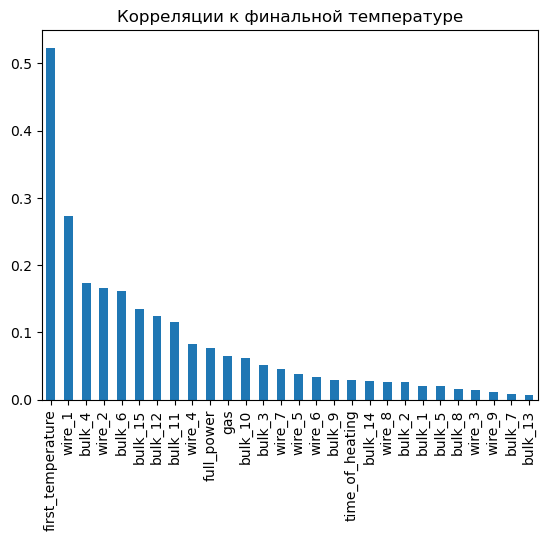

In [99]:
plt.title('Корреляции к финальной температуре')
abs(corr_last_temp).sort_values(ascending= False).plot(kind = 'bar');

Вывод: самое большое влияние оказывают температура с которой чугун был подан на плавку и некоторые примеси. 

# 6 Построение модели

## 6.1. Подготовка выборок

Согласно условиям задачи

In [100]:
random_state = 310124
test_size = 0.25

Подготовим выборки

In [101]:
features = united_new.drop(columns=['last_temperature'])
target = united_new['last_temperature']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= test_size, random_state= random_state)

Проверим рамеры выборок

In [103]:
X_train.shape

(2265, 28)

In [104]:
X_test.shape

(756, 28)

In [105]:
y_train.shape

(2265,)

In [106]:
y_test.shape

(756,)

Можно переходить к построению модели

## 6.2. Построение и выбор модели

Категориальных признаков нет

In [107]:
numeric_features = X_train.columns

params = {}
model = LinearRegression()
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

In [108]:
pipeline = make_pipeline(preprocessor,model)

In [109]:
pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['full_power', 'time_of_heating', 'first_temperature', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'],
      dtype='object'))])),
                ('linearregression', LinearRegression())])

In [110]:
gs = GridSearchCV(pipeline, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error')

In [111]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['full_power', 'time_of_heating', 'first_temperature', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'gas', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9'],
      dtype='object'))])),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, return_train_score=True,
             scoring='neg_mean_absolute_error')

Оценка кросс валидацией

In [112]:
abs(gs.best_score_)

8.698084704712155

MAE > 6.8. Перейдем к бустингу

In [131]:
model = LGBMRegressor(random_state= random_state)

In [152]:
params = {'n_estimators': [15, 20, 55], 'num_leaves': [30, 40, 50], 'max_depth': [15,25,30]}
gs = GridSearchCV(model, params, cv=5, return_train_score=True, scoring='neg_mean_absolute_error')

In [153]:
gs.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.857616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.868653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.868653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.358720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 1812, n

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.192605
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.068985
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.068985
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.857616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start 

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2247
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.068985
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.857616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2325
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1591.868653
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 1812, number of used features: 18
[LightGBM] [Info] Start training from score 1592.358720
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2309
[LightGBM] [Info] Number of data points in the train

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=310124),
             param_grid={'max_depth': [15, 25, 30],
                         'n_estimators': [15, 20, 55],
                         'num_leaves': [30, 40, 50]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [154]:
abs(gs.best_score_)

8.256141499418343

In [155]:
gs.best_params_

{'max_depth': 15, 'n_estimators': 55, 'num_leaves': 30}

Видимо где-то ошибся при подготовке признаков.Не могу понять где (

Выберем модель

In [156]:
model = LGBMRegressor(random_state= random_state, max_depth = 15, n_estimators = 55, num_leaves= 30)

In [157]:
model.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2573
[LightGBM] [Info] Number of data points in the train set: 2265, number of used features: 19
[LightGBM] [Info] Start training from score 1592.069316


LGBMRegressor(max_depth=15, n_estimators=55, num_leaves=30, random_state=310124)

## 6.3. Тест модели

На тестовой выборке

In [159]:
mean_absolute_error(model.predict(X_test), y_test)

8.907788813412374

Сравним с DummyRegressor

In [161]:
model = DummyRegressor(strategy= 'median')
model.fit(X_train,y_train)
mean_absolute_error(model.predict(X_test), y_test)

10.917989417989418

# 7 Общий вывод

MAE получилась > 6.8. Не могу найти ошибку. Пока что вывод писать не смысла. Прошу подсказку